In [1]:
import geopandas as gp
from geopandas.tools import sjoin
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree
import numpy as np
from shapely.geometry import Point, MultiPoint
from fiona.crs import from_epsg
%matplotlib inline

In [2]:
# get the shapefile here http://sensitivecities.com/extra/london.zip
df_london = gp.GeoDataFrame.from_file('data/london')
df_london.crs = from_epsg(4326)
df_london.head()

AREA AREA_CODE       CODE          DESCRIPT0 DESCRIPT1  \
0     0       LBW  E05000405  CIVIL VOTING AREA      None   
1     0       LBW  E05000414  CIVIL VOTING AREA      None   
2     0       LBW  E05000401  CIVIL VOTING AREA      None   
3     0       LBW  E05000400  CIVIL VOTING AREA      None   
4     0       LBW  E05000402  CIVIL VOTING AREA      None   

            DESCRIPTIO                 FILE_NAME  HECTARES  \
0  London Borough Ward  GREATER_LONDON_AUTHORITY   755.173   
1  London Borough Ward  GREATER_LONDON_AUTHORITY   259.464   
2  London Borough Ward  GREATER_LONDON_AUTHORITY   145.390   
3  London Borough Ward  GREATER_LONDON_AUTHORITY   268.506   
4  London Borough Ward  GREATER_LONDON_AUTHORITY   187.821   

                          NAME  NUMBER  NUMBER0  POLYGON_ID TYPE_COD0  \
0       Chessington South Ward      52      733       50840      None   
1  Tolworth and Hook Rise Ward     106      734      117160      None   
2              Berrylands Ward     107      735       50449      None   
3               Alexandra Ward     108      736       50456      None   
4                Beverley Ward     109      737      117161      None   

  TYPE_CODE  UNIT_ID                                           geometry  
0        VA    10884  POLYGON ((-0.3306790212463542 51.3290110115417...  
1        VA    11407  POLYGON ((-0.3084572192029973 51.3758608060460...  
2        VA    11413  POLYGON ((-0.3038496397984196 51.3924869913463...  
3        VA    11420  POLYGON ((-0.2699000817812610 51.3884512045557...  
4        VA    11417  POLYGON ((-0.2466219835559891 51.3992118975100...

# Parse an XML file into a dict

In [5]:
# parse XML into dict
# available from openplaques: https://dl.dropbox.com/u/21695507/openplaques/plaques_20140619.xml
tree = etree.parse("data/plaques_20140619.xml")
root = tree.getroot()

output = dict()
output['raw'] = []
output['crs'] = []
output['lon'] = []
output['lat'] = []

for each in root.xpath('/openplaques/plaque/geo'):
    # check what we got back
    output['crs'].append(each.get('reference_system', None))
    output['lon'].append(each.get('longitude', None))
    output['lat'].append(each.get('latitude', None))
    # now go back up to plaque
    r = each.getparent().xpath('inscription/raw')[0]
    if isinstance(r.text, str):
        output['raw'].append(r.text.lstrip().rstrip())
    else:
        output['raw'].append(None)

# Set up a DataFrame, and use it to construct a GeoDataFrame

In [6]:
df = pd.DataFrame(output)
df = df.replace({'raw': 0}, None)
df = df.dropna()
df[['lon', 'lat']] = df[['lon', 'lat']].astype(float)
df.head()

crs        lat       lon  \
0  WGS84  53.144512 -1.549882   
1  WGS84  53.134787 -1.548879   
2  WGS84  53.138379 -1.555831   
3  WGS84  53.330366 -1.654271   
4  WGS84  55.861110 -4.248807   

                                                 raw  
0  Rockside Hydro 1862-1939\nRAF Hospital during ...  
1  Horseshoe Inn\nc. 1860-2010\nMatlock Green was...  
2                          Crown Hotel \nc 1895-1990  
3  George Herbert Lawrence\n1888-1940\nIndustrial...  
4                  City Chambers. William Young 1888

In [7]:
df_plaques = gp.GeoDataFrame({
    'geometry': [Point(x, y) for x, y in zip(df['lon'], df['lat'])],
    'raw': df['raw']})
# set crs, then convert to OSGB36 if necessary
df_plaques.crs = from_epsg(4326)
# df_plaques['geometry'] = df_plaques['geometry'].to_crs(epsg=2770)

# Spatial Joins ([details here](http://nbviewer.ipython.org/github/geopandas/geopandas/blob/master/examples/spatial_joins.ipynb))

In [8]:
# Perform an inner join between the geometry columns (points, wards) of the plaques and wards dataframes
join_inner_df = sjoin(df_plaques, df_london, how="inner")
len(join_inner_df)

2251

In [15]:
join_inner_df.head()

geometry  \
0  POINT (-0.2246440000000000 51.4930919999999972)   
1  POINT (-0.1990080000000000 51.4990719999999982)   
2  POINT (-0.2878440000000000 51.4890720000000002)   
3  POINT (-0.0745120000000000 51.5244050000000016)   
4  POINT (-0.1752394437789920 51.5118307331363994)   

                                                 raw   AREA AREA_CODE  \
0  Rik Mayall 1958-2014 punched his friend in the...  5.486       LBW   
1  The Trafalgar Way. Kensington. On Monday 21st ...  0.000       LBW   
2  The Trafalgar Way. Brentford & Chiswick. On Mo...  3.263       LBW   
3  William Henry Reynolds 1915-1999 Electrical En...  0.000       LBW   
4  Lancaster Gate platforms  Architect Harry Bell...  0.000       LBW   

        CODE          DESCRIPT0 DESCRIPT1           DESCRIPTIO  \
0  E05000256  CIVIL VOTING AREA      None  London Borough Ward   
1  E05000391  CIVIL VOTING AREA      None  London Borough Ward   
2  E05000347  CIVIL VOTING AREA      None  London Borough Ward   
3  E05000588  CIVIL VOTING AREA      None  London Borough Ward   
4  E05000636  CIVIL VOTING AREA      None  London Borough Ward   

                  FILE_NAME  HECTARES                       NAME  NUMBER  \
0  GREATER_LONDON_AUTHORITY   110.305  Hammersmith Broadway Ward     467   
1  GREATER_LONDON_AUTHORITY   103.896               Holland Ward     472   
2  GREATER_LONDON_AUTHORITY   318.351             Brentford Ward     199   
3  GREATER_LONDON_AUTHORITY    77.575               Weavers Ward     703   
4  GREATER_LONDON_AUTHORITY    95.514             Hyde Park Ward     491   

   NUMBER0  POLYGON_ID TYPE_COD0 TYPE_CODE  UNIT_ID  
0     1239      117148      None        VA    11431  
1     1253       50661      None        VA    11273  
2      810      117105      None        VA    11401  
3     1330       50811      None        VA    10855  
4     1275       50772      None        VA    11124

In [ ]:
# Join the plaque counts *per ward* to the wards
# This works because the result of the dataframe join shows all points and their associated ward code
df_london = df_london.merge(
    join_inner_df['CODE'].value_counts().to_frame(),
    how='left',
    left_on='CODE', right_index=True)
# rename count column to something meaningful
df_london.rename(columns={0: 'Plaque_Count'}, inplace=True)

In [10]:
df_london[['NAME', 'HECTARES', 'Plaque_Count']].dropna().sort('Plaque_Count', ascending=False).head(10)

NAME  HECTARES  Plaque_Count
484                     West End Ward   199.973           165
478                  St. James's Ward   346.379           161
489       Marylebone High Street Ward   100.107            67
501                   Bloomsbury Ward   102.091            66
502    Holborn and Covent Garden Ward   119.493            49
480  Knightsbridge and Belgravia Ward   359.430            42
510               Hampstead Town Ward   244.939            40
245                   Cathedrals Ward   176.822            38
475                 Queen's Gate Ward    60.645            31
508        Frognal and Fitzjohns Ward   153.023            31

In [11]:
# plaque density per square km
df_london['Plaque_Density'] = (df_london['Plaque_Count'] / df_london.area) / 100000
df_london.replace(to_replace={'Plaque_Density': {0: np.nan}}, inplace=True)
df_london[['NAME', 'HECTARES', 'Plaque_Count', 'Plaque_Density']].dropna().sort('Plaque_Density', ascending=False).head(10)

NAME  HECTARES  Plaque_Count  Plaque_Density
628    Langbourn Ward     5.193             8       11.894328
633   Cordwainer Ward     5.965             9       11.650257
635        Cheap Ward     9.161            12       10.113464
642     Cornhill Ward     6.478             8        9.534512
641     Walbrook Ward     7.474             9        9.297560
643  Lime Street Ward     5.096             6        9.091814
648   Candlewick Ward     5.209             6        8.894579
637   Aldersgate Ward     9.795            10        7.881302
639       Bridge Ward     9.421             9        7.376950
636    Bassishaw Ward    10.658            10        7.244112

In [12]:
# fill empty densities with 0. Not ideal.
df_london['Plaque_Density'].fillna(0, inplace=True)

/usr/local/lib/python2.7/site-packages/pandas/computation/expressions.py:184: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


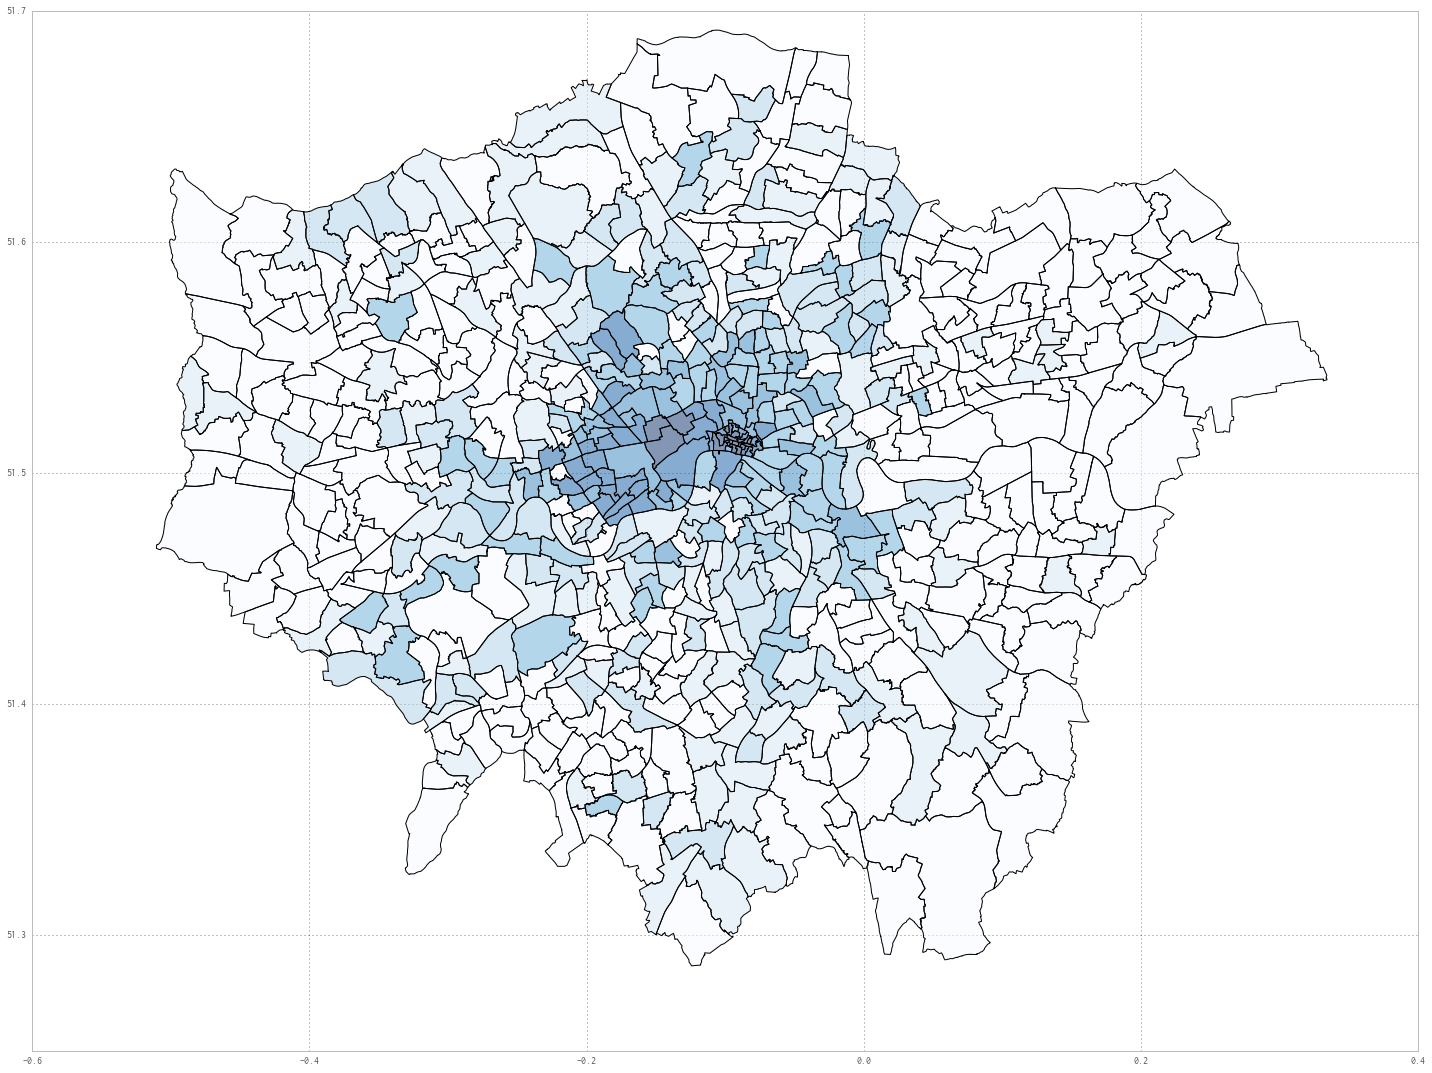

In [13]:
plt.clf()
fig = plt.figure(figsize=(20, 15), dpi=100)
ax = fig.add_subplot(111, axisbg='w', frame_on=True)
df_london.plot(column='Plaque_Density', scheme='natural_breaks', k=7, colormap='Blues', axes=ax)
plt.tight_layout()
plt.show()